# Chapter 7 질문 답변

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

```
구글에서 "When did Marie Curie win her first Nobel Prize? (마리 퀴리는 언제 처음으로 노벨상을 수상했나요?)" 같은 검색을 하면 "1903" 이라는 정확한 답이 나옴

구글은 먼저 쿼리와 관련된 문서를 319,000개 추출하고 추가적인 처리 단계를 수행해 정답을 추출함

이때 정답을 담은 구절(Passage)과 웹 페이지를 함께 보여줌

따라서 이 정답이 유효한지 확인하는 방법은 어렵지 않음

예를 들어 'Which guitar tuning is the best? (가장 좋은 기타 튜닝법은 어떤 것인가요?)' 같은 까다로운 질문을 검색하면 구글은 답을 제공하는 대신 웹 페이지 여러 개를 반환해 이중 하나를 클릭해 직접 정보를 찾도록 함

이 기술의 이면에 있는 일반적인 접근법을 질문 답변(Question Answering(QA))이라 함

여러 종류의 QA 가 있지만 가장 일반적인 방법은 문서에 있는 텍스트 일부를 질문의 답으로 추출하는 추출적 QA(Extractive QA)임

여기서 문서란 웹 페이지, 법률 계약서, 뉴스 기사 등 다양함

관련된 문서를 추려내고 그 문서에서 원하는 답을 추출하는 두 단계 과정이 오늘날 QA 시스템의 기초가 됨

이런 QA 시스템에는 의미 검색 엔진, 지능형 비서, 자동화된 정보 추출기 등이 있음

이 장에서는 이 과정을 적용해 전자상거래 웹사이트에서 흔히 생기는 문제를 해결하겠음

제품을 평가하기 위해 구체적인 질문을 하는 고객을 돕는 작업임

고객 리뷰는 풍부하고 도전적인 QA 의 정보 소스임

이를 통해 어떻게 트랜스포머가 텍스트에서 의미를 추출하는 강력한 독해(Reading Comprehension) 모델로 동작하는지 알아보겠음
```

> NOTE<br>이 장은 추출적 QA 에 초점을 맞추지만, 상황에 따라서는 다른 종류의 QA 가 더 적합함<br>예를 들어 커뮤니티 QA(Community QA)는 스택 오버플로우(Stack Overflow(https://stackoverflow.com)) 같은 포럼의 사용자가 생성한 질문 답변 쌍을 수집함<br>그다음 의미 유사도 검색을 사용해 새 질문에 가장 잘 맞는 답을 찾음<br>'Why is the sky blue? (왜 하늘은 파란가요?)' 같은 개방형 질문에 한 문단 길이의 복잡한 답을 생성하도록 만들어진 롱-폼 QA(Long-Form QA)도 있음<br>놀랍게도 테이블(Table) 데이터에도 QA 를 수행할 수 있음<br>심지어 TAPAS(https://oreil.ly/vVPWO)라는 트랜스포머 모델은 최종 답을 생성하기 위해 집계까지 함!

## 7.1 리뷰 기반 QA 시스템 구축하기

```
온라인에서 물건을 구매해봤다면 고객 리뷰를 믿고 결정을 내린 경험이 있을 것임

이런 리뷰는 종종 'Does this guitar come with a strap? (이 기타를 주문하면 스트랩도 같이 오나요?)' 또는 'Can I use this camera at night? (이 카메라를 밤에 쓸 수 있을까요?)' 같은 특정 질문의 답을 찾을 때 도움이 됨

이런 질문의 답은 제품 설명에서 찾기가 어려움

대안으로 아마존(Amazon) 같은 웹사이트에서 제공하는 커뮤니티 QA 플랫폼에 질문을 올리는 방법이 있음

하지만 보통은 며칠을 기다려야 답변이 옴

구글 예시처럼 즉각 답변을 받으면 좋지 않을까?

그래서 이 절에서는 트랜스포머를 사용해 QA 시스템을 만들겠음
```

### 7.1.1 데이터셋

```
QA 시스템을 만들 때 사용할 데이터셋은 여섯 분야의 제품과 서비스에서 10,000여개의 영어 고객 리뷰로 구성된 SubjQA 임

데이터셋을 구성하는 여섯 분야는 트립어드바이저(TripAdvisor), 음식점, 영화, 책, 전자 제품, 식료품 임

각 리뷰에는 질문에 맞게 한 문장 이상을 사용해 답변할 정보가 들어있음
```

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

```
이 데이터셋은 대부분의 질문과 답이 주관적이라는 점이 흥미로움

즉 모든 리뷰가 사용자의 개인 경험에 의존함

이런 점에서, 이 작업은 'What is the currency of the United Kingdom? (영국에서 사용하는 통화는 무엇인가요?)' 같이 사실 여부가 명확한 질문의 답을 찾는 작업보다 어려움

위 그림의 예시에서 그 이유를 살펴보자

첫째, '나쁜 품질(Poor Quality)'에 관한 쿼리를 입력했음

나쁜 품질에 대한 기준은 주관적이며 품질이란 기준조차도 사람에 따라 정의가 다름

둘째, 쿼리의 중요 부분이 리뷰에 전혀 나타나지 않음

이는 키워드 검색이나 입력 질문을 재구성하는 간단한 방식으로는 답을 찾지 못한다는 의미임

이런 특징 덕분에 SubjQA 데이터셋은 리뷰 기반 QA 모델을 벤치마킹하기에 현실적임

위 그림과 같은 사용자 생성 콘텐츠가 실제로 보게 될 리뷰와 거의 비슷하기 때문임
```

>NOTE<br>QA 시스템은 일반적으로 쿼리에 응답할 때 참조하는 데이터의 도메인으로 분류함<br>클로즈드 도메인 QA(Closed Domain QA)는 좁은 주제(가령, 단일 제품 카테고리)에 대해 질문을 다룸<br>반면 오픈 도메인 QA(Open Domain QA)는 거의 모든 주제(가령, 아마존의 전체 제품 카탈로그)에 대한 질문을 다룸<br>대체로 클로즈드 도메인 QA 가 오픈 도메인 QA 보다 검색하는 문서의 개수가 적음

```
허깅페이스 허브(https://oreil.ly/iO0c5)에서 이 데이터셋을 다운로드하면서 시작해보자

4장과 마찬가지로 get_dataset_config_names() 함수를 사용하여 어떤 서브셋을 사용할 수 있는지 확인하자
```

In [2]:
from datasets import get_dataset_config_names

In [3]:
domains = get_dataset_config_names('subjqa')
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

```
여기에는 전자 제품용 QA 시스템을 구축하는 데 초점을 맞추겠음

electronics 서브셋을 다운로드하려면 load_dataset() 함수의 name 매개변수에 이 값을 전달함
```

In [4]:
from datasets import load_dataset

In [5]:
subjqa = load_dataset('subjqa', name='electronics')

Reusing dataset subjqa (/home/heerak/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

```
허브에 있는 여느 질문 답변 데이터셋과 마찬가지로, SubjQA 는 각 질문의 답을 중첩된 딕셔너리로 저장함

예를 들어 answers 열에 있는 행 하나를 확인해보자
```

In [6]:
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


```
답은 text 필드에 저장됐음

answer_start 에 시작 문자의 인덱스가 있음

이 데이터셋을 손쉽게 탐색하기 위해 다음처럼 flatten() 메서드로 중첩된 열을 펼치고 각 분할을 판다스 DataFrame 으로 변환하겠음
```

In [7]:
import pandas as pd

In [8]:
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f'{split}에 있는 질문 개수: {df["id"].nunique()}')

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


```
샘플이 총 1,908개 있는 비교적 작은 데이터셋임

추출적 QA 데이터셋을 레이블링하기 위해 도메인 전문가를 고용하는 것은 노동 집약적이고 비용도 큼

따라서 이 데이터셋은 실전 시나리오에 가까움

예를 들어 추출적 QA 를 위한 법률 문서 데이터셋 CUAD 는 13,000개 샘플을 레이블링할 법률 전문가 고용 비용을 고려하면 2백만 달러의 가치가 있는 것으로 추정됨
```

```
SubjQA 데이터셋에 있는 많은 열 중 이 장에서 QA 시스템을 구축할 때 흥미로운 열을 추렸음
```

|열 이름|설명|
|---|---|
|title|각 제품에 연관된 ASIN(Amazon Standard Identification Number)|
|question|질문|
|answers.text|사람이 레이블링한 리뷰 텍스트 일부|
|answers.answer_start|답이 시작하는 문자 인덱스|
|context|고객 리뷰|

```
이 열에 초점을 맞춰 훈련 샘플을 몇 개 살펴보겠음

sample() 메서드를 사용해 랜덤하게 샘플을 선택함
```

In [9]:
qa_cols = ['title', 'question', 'answers.text',
           'answers.answer_start', 'context']
sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


```
이 샘플에서 몇 가지 특징이 관찰됨

첫째, 질문이 문법적으로 바르지 않음

전자상거래 웹사이트의 FAQ 섹션에서 흔히 있는 일임

둘째, 빈 answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담겼음

마지막으로, 시작 인덱스와 답변 길이를 사용해 리뷰에서 답변에 해당하는 텍스트를 추출할 수 있음
```

In [10]:
start_idx = sample_df['answers.answer_start'].iloc[0][0]
end_idx = start_idx + len(sample_df['answers.text'].iloc[0][0])
sample_df['context'].iloc[0][start_idx:end_idx]

'this keyboard is compact'

```
훈련 세트에 대략 어떤 종류의 질문이 있는지 알아보기 위해 몇 개의 흔한 단어로 시작하는 질문의 개수를 카운트해보겠음
```

In [11]:
import matplotlib.pyplot as plt

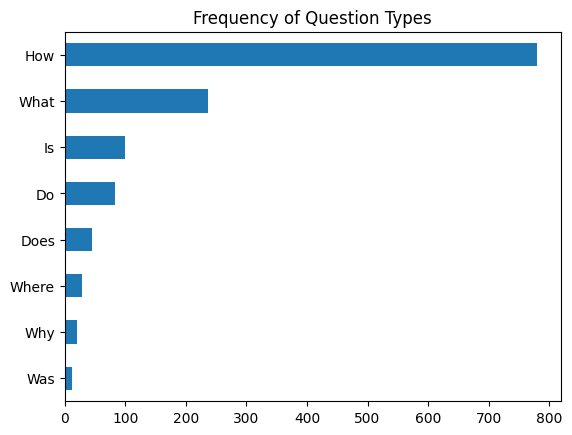

In [12]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs['train']['question'].str.startswith(q).value_counts()[True]
    
pd.Series(counts).sort_values().plot.barh()
plt.title('Frequency of Question Types')
plt.show()

```
'How', 'What', 'Is' 로 시작하는 질문이 가장 많음

이 샘플들을 조금 더 확인해보자
```

In [13]:
for question_type in ['How', 'What', 'Is']:
    for question in (dfs['train'][dfs['train'].question.str.startswith(question_type)]
                     .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


#### 스탠퍼드 질문 답변 데이터셋

SubjQA 의 형식인 (**질문**, **리뷰**, **[답변]**)은 추출적 QA 데이터셋에서 널리 사용되는데, 스탠퍼드 질문 답변 데이터셋(Stanford Question Answering Dataset(SQuAD))에서 처음 사용된 방식임

유명한 이 데이터셋은 컴퓨터가 텍스트 문단을 읽고 관련 질문에 답변이 가능한지 테스트할 때 많이 사용됨

원래 이 데이터셋은 수백 개의 위키피디아 영어 문서에서 샘플링하고 크라우드소싱(CrowdSourcing)을 통해 각 문단에서 일련의 질문과 답을 생성해 만들어졌음

SQuAD 의 최초 버전은 각 질문의 답이 해당 구절 안에 반드시 존재했는데, 시퀀스 모델이 텍스트에서 정답을 추출하는 속도가 금세 사람을 앞지르기 시작했음

작업의 난도를 높이기 위해 주어진 텍스트와 관련되지만 텍스트만으로는 답변할 수 없는 적대적인 질문(Adversarial Question)으로 SQUAD 1.1 을 보강해 SQuAD 2.0 을 만들었음

2019년 이후에 나온 모델 대부분이 사람의 능력을 뛰어넘었음

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

하지만 이런 초인적인 성능이 진정한 독해 능력을 나타내진 않음

답변 불가한 질문의 답은 보통 반의어 같은 텍스트에 있는 패턴을 통해 식별해내기 때문임

이 문제를 해결하기 위해 구글은 자연 질문(Natural Question(NQ)) 데이터셋을 릴리스했음

NQ 는 구글 검색 사용자에게서 수집한 사실 탐색(Fact Seeking) 질문으로 구성되며, NQ 에 있는 답변은 SQuAD 에 있는 답변보다 훨씬 더 길며, 더 어려운 벤치마크를 만듦

```
데이터셋을 살펴보았으니 어떻게 트랜스포머로 텍스트에서 답을 추출하는지 자세히 이해해보겠음
```

### 7.1.2 텍스트에서 답 추출하기

```
QA 시스템에서는 가장 먼저 고객 리뷰에 있는 텍스트에서 답변에 사용할 만한 부분을 식별해 낼 방법을 찾아야 함

예를 들어 'Is it waterproof? (이거 방수되나요?)' 라는 질문에 'This watch is waterproof at 30m depth (이 시계는 30m까지 방수)'를 출력함

이렇게 하려면 다음 방법을 이해해야 함
```

- 지도 학습 문제로 구성하기
- QA 작업을 위해 텍스트를 토큰화하고 인코딩하기
- 모델의 최대 문맥 크기를 초과하는 긴 텍스트 다루기

```
문제를 구성하는 방법부터 알아보자
```

#### 범위 분류

```
문제를 범위 분류(Span Classification) 작업으로 구성하는 방법은 텍스트에서 답을 추출하는 가장 일반적인 방법임

이 작업에서 모델이 예측해야 하는 레이블은 답변 범위에 해당하는 시작 토큰과 종료 토큰임

이 과정을 살펴보자
```

<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

```
훈련 세트에는 비교적 적은 1,295개 샘플만 있으므로 SQuAD 같은 대규모 QA 데이터셋에서 미세 튜닝한 언어 모델로 시작하는 편이 좋음

이런 모델은 대체로 독해 능력이 우수하고 더 정확한 시스템을 구축하기 위한 좋은 기준 모델로 사용됨

이전 장처럼 사전 훈련된 모델을 사용해 작업에 특화된 헤드를 미세 튜닝하는 일반적인 방식과 조금 다름

예를 들어, 2장에서는 클래스 개수가 현재 데이터셋과 달라서 분류 헤드를 미세 튜닝해야 했음

그러나 추출적 QA 는 레이블 구조가 데이터셋에 따라 달라지지 않기 때문에 미세 튜닝한 모델로 시작해도 무방함

허깅페이스 허브(https://oreil.ly/dzCsC)에서 모델 탭에 'squad' 를 검색해 추출적 QA 모델 목록을 보겠음
```

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/> 

```
그림에 나온 대로, 이 글을 쓸 때 QA 모델은 350개가 넘음

이중 어떤 모델을 선택해야 할까?

결정에는 여러 가지 요인이 작용함

주어진 말뭉치가 단일 언어인지 다중 언어인지에 따라 다르고, 제품 환경에서 모델을 실행하는 제약 조건에 따라서도 달라짐

표에 좋은 구축 기반이 되는 모델을 정리했음
```

|트랜스포머|설명|파라미터 개수|SQuAD 2.0 에서 F1-점수|
|---|---|:---:|:---:|
|MiniLM|99% 성능을 유지하면서 두 배 빠른 BERT 기반의 압축 버전임|66M|79.5|
|RoBERTa-base|RoBERTa 모델이 BERT 보다 성능이 더 높고 단일 GPU 를 사용해 대부분의 QA 데이터셋에서 미세 튜닝이 가능|125M|83.0|
|ALBERT-XXL|SQuAD 2.0 에서 최고의 성능을 내지만 계산 집약적이고 배포가 어려움|235M|88.1|
|XLM-RoBERTa-large|강력한 제로샷(Zero-Shot) 성능을 내며 100개 언어를 위한 다중 언어 모델임|570M|83.8|

```
이 장의 목적상 미세 튜닝한 MiniLM 모델을 사용하겠음

이 모델은 훈련 속도가 높아서 빠르게 반복하며 여러 기술을 살펴보기 좋음

늘 그렇듯이 텍스트를 인코딩할 토크나이저가 가정 먼저 필요함

그럼 QA 작업에서 토큰화가 어떻게 이루어지는지 알아보자
```

#### QA 를 위한 텍스트 토큰화

```
텍스트를 인코딩하기 위해 허깅페이스 허브(https://oreil.ly/df5Cu)에서 MiniLM 모델의 체크포인트를 로드하겠음
```

In [14]:
from transformers import AutoTokenizer

2023-02-03 16:52:00.874046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 16:52:01.431909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-03 16:52:01.431960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-02-03 16:52:01.431965: W tensorflow

In [15]:
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [16]:
tokenizer

PreTrainedTokenizerFast(name_or_path='deepset/minilm-uncased-squad2', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

```
모델을 작동해보기 위해 짧은 텍스트에서 답을 추출하겠음

추출적 QA 작업에서는 입력을 (질문, 문맥) 쌍 형태로 제공함

따라서 다음과 같이 두 값을 모두 토크나이저에 전달함
```

In [17]:
question = 'How much music can this hold?'
context = 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'
inputs = tokenizer(question, context, return_tensors='pt')

In [18]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

```
파이토치 Tensor 객체가 반환되므로 이를 사용해 모델의 정방향 패스를 실행해야 함

토큰화된 입력을 표로 확인하면 다음과 같음
```

In [19]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient='index')
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


```
input_ids 와 attention_mask 텐서는 익숙함

token_type_ids 텐서는 입력에서 어떤 부분이 질문과 문맥에 해당하는지 나타냄 (0은 질문 토큰, 1은 문맥 토큰을 나타냄)

토크나이저가 QA 작업에서 입력을 포맷팅하는 방법을 이해하기 위해 input_ids 텐서를 디코딩해보자
```

In [20]:
print(tokenizer.decode(inputs['input_ids'][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


```
QA 샘플마다 다음 포맷으로 입력이 구성됨

[CLS] 질문 토큰 [SEP] 문맥 토큰 [SEP]

첫 번째 [SEP] 토큰의 위치는 token_type_ids 에 의해 결정됨

텍스트를 토큰화했으니 QA 헤드와 함께 모델 객체를 초기화하고 입력을 정방향 패스에 통과시킴
```

In [21]:
import torch

from transformers import AutoModelForQuestionAnswering

In [22]:
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


```
QA 헤드는 QuestionAnsweringModelOutput 객체를 출력함

QA 헤드는 인코더의 은닉 상태를 받아 시작과 종료 범위의 로짓을 계산하는 선형 층에 해당함

이는 QA 작업을 4장의 개체명 인식과 비슷하게 토큰 분류 형태로 다룬다는 의미임

출력을 답의 범위로 변환하기 위해 먼저 시작과 종료 토큰의 로짓이 필요함
```

In [23]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

```
이 로짓의 크기를 입력 ID 와 비교해보자
```

In [24]:
print(f'입력 ID 크기: {inputs.input_ids.size()}')
print(f'시작 로짓 크기: {start_logits.size()}')
print(f'종료 로짓 크기: {end_logits.size()}')

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


```
두 로짓(시작과 종료)은 각 입력 토큰에 연관됨

아래 그림에 표현된 대로 큰 양수 로짓은 가능성이 높은 시작과 종료 토큰 후보에 해당함

이 예시에서는 모델이 숫자 1과 6,000에 가장 높은 시작 토큰 로짓을 할당했음

질문이 어떤 양에 관한 것이므로 이해됨

마찬가지로 로짓이 가장 높은 종료 토큰은 'minute' 과 'hours' 임
```

In [25]:
import numpy as np
import matplotlib.pyplot as plt

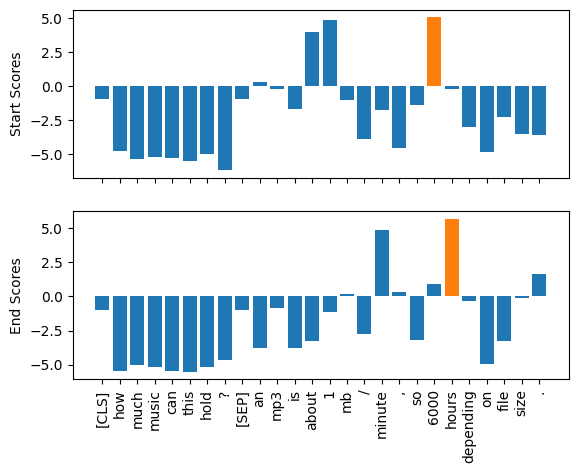

In [26]:
s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ['C0' if s != np.max(s_scores) else 'C1' for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel('Start Scores')
colors = ['C0' if s != np.max(e_scores) else 'C1' for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel('End Scores')
plt.xticks(rotation='vertical')
plt.show()

```
최종 답을 얻기 위해 시작 토큰과 종료 토큰의 로짓에 argmax 함수를 적용하고 입력에서 이 범위를 슬라이싱함

다음 코드는 이런 단계를 수행하고 결과를 디코딩해 텍스트로 출력함
```

In [27]:
import torch

In [28]:
start_logits

tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]])

In [29]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs['input_ids'][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f'질문: {question}')
print(f'답변: {answer}')

질문: How much music can this hold?
답변: 6000 hours


```
성공이다!

트랜스포머스는 편리하게도 이런 모든 전처리 단계와 후처리 단계가 전용 파이프라인 안에 있음

다음처럼 토크나이저와 미세 튜닝된 모델을 전달해 파이프라인을 초기화함
```

In [30]:
from transformers import pipeline

In [31]:
pipe = pipeline('question-answering', model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516181230545044,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.2208295613527298,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253508388996124,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

```
답변 외에도, 이 파이프라인은 (로짓에 소프트맥스 함수를 적용해) 모델이 추정한 확률을 score 필드로 제공함

한 문맥에서 여러 답을 비교할 때 편리함

또 topk 매개변수를 사용하면 모델이 여러 개의 답을 예측함

answers.answer_start 가 비어있는 SubjQA 샘플처럼 이따금 답변이 불가한 질문도 있음

모델은 이 경우 [CLS] 토큰에 높은 시작 점수와 종료 점수를 할당함

파이프라인은 이 출력을 빈 문자열로 매핑함
```

In [32]:
pipe(question='Why is there no data?', context=context,
     handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

>NOTE<br>간단한 이 예에서는 해당 로짓에 argmax 를 적용해 시작과 종료 인덱스를 얻었음<br>하지만 이 방법은 문맥 대신 질문에 속한 토큰을 선택해서 범위가 벗어난 답을 생성할 때도 있음<br>실전에서는 범위 내에 있는지, 시작 인덱스가 종료 인덱스 앞에 있는지 등의 다양한 제약 조건을 따라 파이프라인이 최상의 시작 인덱스와 종료 인덱스의 조합을 계산함

#### 긴 텍스트 다루기

In [33]:
def compute_input_length(row):
    inputs = tokenizer(row['question'], row['context'])
    return len(inputs['input_ids'])

```
독해 모델의 결점 하나는 종종 문맥에 있는 토큰이 모델의 최대 시퀀스 길이(보통 최대 수백 개 토큰)를 초과한다는 것임

아래 그림을 보면 SubjQA 훈련 세트의 상당 부분이 MiniLM 의 문맥 크기인 512 토큰에 맞지 않는 질문-문맥 쌍을 가짐
```

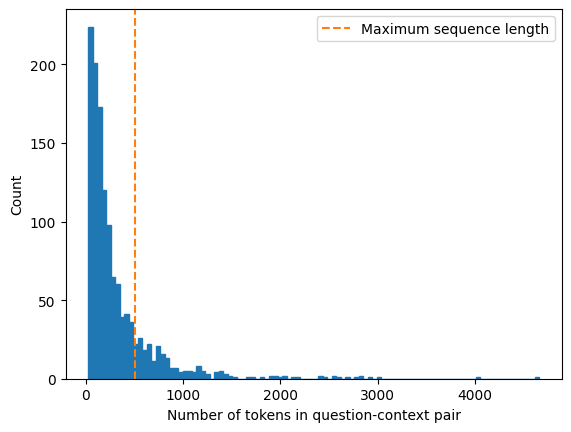

In [34]:
dfs['train']['n_tokens'] = dfs['train'].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs['train']['n_tokens'].hist(bins=100, grid=False, ec='C0', ax=ax)
plt.xlabel('Number of tokens in question-context pair')
ax.axvline(x=512, ymin=0, ymax=1, linestyle='--', color='C1',
           label='Maximum sequence length')
plt.legend()
plt.ylabel('Count')
plt.show()

```
텍스트 분류 같은 그 외 작업에서는 정확한 예측을 생성하기 위해 [CLS] 토큰 임베딩에 충분한 정보가 담겼다고 가정하고 그냥 긴 텍스트를 잘랐음

하지만 QA 작업에서는 이런 전략이 문제를 일으킴

질문의 답이 문맥의 끝에 있으면 텍스트를 잘랐을 때 답이 삭제됨

이 문제를 다루는 전형적인 방법은 아래 그림처럼 입력에 슬라이딩 윈도(Sliding Window)를 적용하는 것임

각 윈도는 모델의 문맥 크기에 맞는 토큰 리스트가 됨
```

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

```
트랜스포머스는 토크나이저에 return_overflowing_tokens=True 를 설정해 슬라이딩 윈도를 만듦

슬라이딩 윈도의 크기는 max_seq_length 매개변수로, 스트라이드(Stride)의 크기는 doc_stride 로 조절함

훈련 세트에 첫 번째 샘플을 사용해 슬라이딩 윈도의 작동 방식을 확인하겠음
```

In [35]:
example = dfs['train'].iloc[0][['question', 'context']]
tokenized_example = tokenizer(example['question'], example['context'],
                              return_overflowing_tokens=True,
                              max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [36]:
tokenized_example

{'input_ids': [[101, 2129, 2003, 1996, 3321, 1029, 102, 1045, 2031, 2018, 12849, 4757, 2132, 19093, 1999, 1996, 2627, 1010, 4013, 26424, 2050, 1998, 1053, 2480, 1011, 5585, 1012, 1996, 12849, 4757, 3417, 9331, 3217, 2003, 12109, 1998, 2038, 2307, 3321, 3433, 1012, 1996, 2147, 2307, 2007, 2026, 11924, 3042, 1998, 2064, 2022, 1000, 4565, 2039, 1000, 2000, 2022, 3344, 1999, 2026, 9055, 6598, 2030, 3274, 4524, 2302, 2893, 24514, 2098, 1012, 2027, 2024, 2200, 2422, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 102], [101, 2129, 2003, 1996, 3321, 1029, 102, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 2305, 1998, 2154, 2488, 2084, 2151, 4540, 1011, 13007, 2071, 2022, 1998, 2024, 2471, 2004, 2204, 2004, 1996, 4013, 26424, 2050, 1012, 2027, 2024, 1000, 2330, 2250, 1000, 2132, 19093, 2061,

```
이 경우 윈도마다 input_ids 의 리스트를 하나씩 얻음

각 위도의 토큰 개수를 확인해보자
```

In [37]:
for idx, window in enumerate(tokenized_example['input_ids']):
    print(f'#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.')

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


```
마지막으로 input_ids 를 디코딩해 두 윈도가 어디서 겹치는지 확인하겠음
```

In [38]:
for window in tokenized_example['input_ids']:
    print(f'{tokenizer.decode(window)} \n')

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



```
이제 QA 모델이 텍스트에서 답을 추출하는 방법을 이해했으니, 엔드-투-엔드 QA 파이프라인을 만드는 데 필요한 다른 구성 요소를 알아보자.
```

### 7.1.3 헤이스택을 사용해 QA 파이프라인 구축하기

```
앞서 간단한 답변 추출 예제에서는 질문과 문맥을 모두 모델에 제공했음

하지만 시스템의 실제 사용자는 제품에 대한 질문만 제공함

따라서 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요함

이를 수행하는 방법 하나는 해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입하는 것임

이 방법은 간단하지만 문맥이 극도로 길어져 때로는 사용자 쿼리에 대한 레이턴시(Latency)를 수용하지 못한다는 단점이 있음

예를 들어 제품마다 평균적으로 30개 리뷰가 있고 각 리뷰를 처리하는 데 100밀리초가 걸린다고 해보자.

답을 구하기 위해 모든 리뷰를 처리한다면 사용자 쿼리마다 평균 3초의 레이턴시가 발생함

전자상거래 웹사이트에서는 너무 긴 시간임

최신 QA 시스템은 두 가지 주요 구성 요소로 이루어진 리트리버-리더(Retriever-Reader) 구조를 기반으로 이 문제를 처리함
```

##### 리트리버

```
쿼리에서 관련된 문서를 추출함

리트리버는 일반적으로 희소 아니면 밀집으로 구분함

희소 리트리버(Sparse Retriever)는 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현함

이 벡터의 내적(Inner Product)을 계산해 쿼리와 문서의 관련성을 결정함

반면 밀집 리트리버(Dense Retriever)는 트랜스포머 같은 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩(밀집 벡터)으로 표현함

이런 임베딩이 의미를 인코딩하므로 밀집 리트리버는 쿼리의 내용을 이해해 검색 정확도를 향상시킴
```

##### 리더

```
리트리버가 제공한 문서에서 답을 추출함

리더는 대개 독해 모델이지만 이 장의 끝에서 자유 형식의 답변을 생성하는 모델을 살펴보겠음
```

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

```
위 그림을 보면 리트리버가 추출한 문서나 리더가 추출한 답에 후처리를 적용하는 구성 요소도 있음

예를 들어 리더에 혼동을 일으키는 잡음이나 관련 없는 요소를 제외하기 위해 추출된 문서를 다시 랭킹하는 작업을 진행함

마찬가지로 긴 문서에 있는 여러 구절에서 정답이 나오면 종종 리더의 답을 후처리할 필요가 있음

QA 시스템을 만들기 위해, NLP 전문 독일 기업 딥셋(Deepset(https://deepset.ai))이 개발한 헤이스택(Haystack(https://haystack.deepset.ai)) 라이브러리를 사용하겠음

헤이스택은 리트리버-리더 아키텍처를 기반으로 하고, 이런 시스템 구축과 관련된 많은 복잡도를 추상화하며 트랜스포머스와 긴밀하게 통합됐음

헤이스택으로 QA 파이프라인을 만들 때는 리트리버와 리더 외에 두 가지 구성 요소가 더 있음
```

##### 문서 저장소

```
쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 데이터베이스임
```

##### 파이프라인

```
사용자 쿼리가 잘 흘러가도록 QA 시스템의 모든 구성 요소를 결합하고 여러 리트리버에서 추출한 문서를 합치는 등의 기능을 함
```

<br>

```
이 절에서는 이런 구성 요소를 사용해 프로토타입(Prototype) QA 파이프라인을 빠르게 구축하는 방법을 알아보겠음

그 뒤에는 성능을 높이는 방법도 살펴보겠음
```

> WARNING<br>이 장에서 사용하는 헤이스택 라이브러리 버전은 0.9.0 임<br>0.10.0 버전(https://oreil.ly/qbqgv)은 리트리버나 리더가 성능에 영향을 미치는지 더 쉽게 조사하기 위해 파이프라인과 평가 API 가 재설계됐음<br>새로운 API 를 반영한 이 장의 코드를 참고하려면 깃허브 저장소(https://github.com/rickiepark/nlp-with-transformers/blob/main/07_question-answering_v2.ipynb)를 확인하자

#### 문서 저장소 초기화하기

```
헤이스택에서 사용 가능한 문서 저장소는 다양하며, 저장소마다 조합할 수 있는 전용 리트리버가 있음

표에 희소 리트리버(TF-IDF, BM25)와 밀집 리트리버(Embedding, DPR)에 각각 호환되는 문서 저장소를 정리했음

약어의 의미는 나중에 설명하겠음
```

||메모리|Elasticsearch|FAISS|Milvus|
|---|:---:|:---:|:---:|:---:|
|TF-IDF|Yes|Yes|No|No|
|BM25|No|Yes|No|No|
|Embedding|Yes|Yes|Yes|Yes|
|DPR|Yes|Yes|Yes|Yes|

```
희소 리트리버와 밀집 리트리버를 이 장에서 모두 살펴보므로 양쪽 리트리버에 모두 호환되는 ElasticsearchDocumentStore 를 사용하겠음

일래스틱서치(Elasticsearch)는 텍스트, 수치, 지리 데이터, 구조적 데이터, 비구조적 데이터를 포함해 다양한 데이터 타입을 처리하는 검색 엔진임

대용량 데이터를 저장하고 전체 텍스트(Full Text) 검색으로 빠르게 필터링하므로 특히 QA 시스템 개발에 잘 맞음

인프라 분석을 위한 업계 표준이라는 이점도 있음

따라서 회사에서는 이미 일래스틱서치 클러스터가 있을 가능성이 높음

문서 저장소를 초기화하려면 먼저 일래스틱서치를 다운로드하고 설치해야 함

일래스틱서치 가이드(https://oreil.ly/bgmKq)를 따라 wget 으로 최신 리눅스용 릴리스를 다운로드하고 tar 셸 명령으로 압축을 풂
```

In [39]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

tar: elasticsearch-7.9.3/lib/elasticsearch-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-plugin-classloader-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/java-version-checker-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-launchers-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-x-content-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-cli-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-core-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-secure-sm-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/elasticsearch-geo-7.9.3.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/lucene-core-8.6.2.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/lucene-analyzers-common-8.6.2.jar: Cannot open: File exists
tar: elasticsearch-7.9.3/lib/lucene-backward-codecs-8.

```
이제 일래스틱서치 서버를 시작함

모든 코드는 주피터 노트북에서 실행하기 때문에 파이썬의 Popen() 함수를 사용해 새로운 프로세스를 시작함

이 서브프로세스를 백그라운드에서 실행하기 위해 chown 셸 명령을 사용하겠음
```

In [40]:
import os

from subprocess import Popen, PIPE, STDOUT

In [41]:
'''
# 백그라운드 프로세스로 일래스틱서치를 실행합니다.
!echo 'tmax1234' | sudo -S chown -R daemon:daemon elasticsearch-7.9.3
# preexec_fn=lambda: os.setuid(1) 이거 추가하면 에러가 나네;;
es_server = Popen(args=['elasticsearch-7.9.3/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# 일래스틱서치가 시작할 때까지 기다립니다.
!sleep 30
'''

"\n# 백그라운드 프로세스로 일래스틱서치를 실행합니다.\n!echo 'tmax1234' | sudo -S chown -R daemon:daemon elasticsearch-7.9.3\n# preexec_fn=lambda: os.setuid(1) 이거 추가하면 에러가 나네;;\nes_server = Popen(args=['elasticsearch-7.9.3/bin/elasticsearch'],\n                  stdout=PIPE, stderr=STDOUT)\n# 일래스틱서치가 시작할 때까지 기다립니다.\n!sleep 30\n"

In [43]:
# 또는 도커가 설치되어 있다면
from haystack.utils import launch_es

launch_es()

INFO - haystack.modeling.model.optimization -  apex not found, won't use it. See https://nvidia.github.io/apex/
ERROR - root -  Failed to import 'magic' (from 'python-magic' and 'python-magic-bin' on Windows). FileTypeClassifier will not perform mimetype detection on extensionless files. Please make sure the necessary OS libraries are installed if you need this functionality.
Unable to find image 'elasticsearch:7.9.2' locally
7.9.2: Pulling from library/elasticsearch
75f829a71a1c: Pulling fs layer
12a20a45aa50: Pulling fs layer
7d49bb9ac613: Pulling fs layer
98dcf7a2301a: Pulling fs layer
26d68d841d2e: Pulling fs layer
db71e2f6acdd: Pulling fs layer
6d58f7bd0cd7: Pulling fs layer
161752ba6659: Pulling fs layer
8adf2f929b9e: Pulling fs layer
db71e2f6acdd: Waiting
8adf2f929b9e: Waiting
26d68d841d2e: Waiting
98dcf7a2301a: Waiting
12a20a45aa50: Download complete
98dcf7a2301a: Download complete
75f829a71a1c: Verifying Checksum
75f829a71a1c: Download complete
7d49bb9ac613: Verifying Checksum

aedf4a0f04175bf3fccf0bd2869aee51f2aef1c2e029fb7f0c6577a9b3da551f


```
Popen() 함수에서 args 로 실행할 프로그램을 지정함

stdout=PIPE 는 표준 출력을 위해 새로운 파이프(Pipe)를 만들고 stderr=STDOUT 로 지정하면 도일한 파이프로 에러가 수집됨

preexec_fn 매개변수에 사용할 서브프로세스의 아이디를 지정함

기본적으로 일래스틱서치는 포트 9200 으로 로컬에서 실행됨

따라서 localhost 로 HTTP 요청을 보내서 연결을 테스트함
```

In [44]:
!curl -X GET 'localhost:9200/?pretty'

{
  "name" : "aedf4a0f0417",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "C3axA3NcQX6lPyWsasG6_g",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


```
일래스틱서치 서버를 설치하고 실행했으므로, 문서 저장소 객체를 초기화하겠음
```

In [45]:
# document_store -> document_stores
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

In [46]:
# 밀집 리트리버에서 사용할 문서 임베딩을 반환함
document_store = ElasticsearchDocumentStore(return_embedding=True)

INFO - haystack.telemetry -  Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://haystack.deepset.ai/guides/telemetry


In [49]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋음
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents('document')
    document_store.delete_documents('label')

```
기본적으로 ElasticsearchDocumentStore 는 일래스틱서치에 두 개의 인덱스를 만듦

문서를 저장하는 document 와 답의 범위를 저장하는 label 임

여기서는 SubjQA 리뷰로 document 인덱스를 채우겠음

헤이스택 문서 저장소는 다음처럼 text 와 meta 키를 가진 딕셔너리의 리스트를 기대함

{
    'text': '<the-context>',
    'meta': {
        'field_01': '<additional-metadata>',
        'field_02': '<additional-metadata>',
        ...
    }
}

meta 에 있는 필드를 사용해 검색 과정에서 필터를 적용함

제품과 질문 ID 로 필터링할 수 있도록 SubjQA 의 item_id 와 id 열, 그리고 해당되는 분할 이름을 포함시키겠음

다음처럼 DataFrame 에 있는 샘플을 순회하면서 write_documents() 메서드로 인덱스에 추가함
```

In [51]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다.
    docs = [{'content': row['context'],
             'id': row['review_id'],
             'meta': {'item_id': row['title'],
                      'question_id': row['id'],
                      'split': split}}
            for _, row in df.drop_duplicates(subset='context').iterrows()]
    document_store.write_documents(docs, index='document')
    
print(f'{document_store.get_document_count()}개 문서가 저장됐습니다.')

1615개 문서가 저장됐습니다.


#### 리트리버 초기화하기

```
일래스틱서치 문서 저장소는 모든 헤이스택 리트리버와 조합이 가능함

('Best Match 25'의 약자인) BM25 기반의 희소 리트리버를 먼저 사용해보자.

BM25 는 고전적인 TF-IDF 알고리즘을 개선한 버전으로 일래스틱서치에서 효율적으로 검색할 수 있는 희소 벡터로 질문과 문맥을 표현함

BM25 점수는 검색 쿼리에서 얼마나 많은 텍스트가 일치하는지 측정함

그다음 TF 값을 빠르게 포화시키고 짧은 문서가 긴 문서보다 선호되도록 문서 길이로 정규화해 TF-IDF 를 개선함

헤이스택에서 ElasticsearchRetriever 의 기본 리트리버는 BM25 임

검색하려는 문서 저장소를 지정해 이 클래스의 객체를 만들어보자.

haystack 1.4 에서 ElasticsearchRetriever 가 BM25Retriever 로 바뀌었음

여전히 버전 1.5 에서 ElasticsearchRetriever 를 사용할 수 있지만 향후 버전에서 삭제될 수 있음
```

In [52]:
from haystack.nodes.retriever import BM25Retriever

In [53]:
bm25_retriever = BM25Retriever(document_store=document_store)

```
훈련 세트에 있는 한 전자 제품에 대한 간단한 쿼리를 살펴보자.

리뷰 기반 QA 시스템에서는 단일 아이템으로 쿼리를 제한하는 것이 중요함

그렇지 않으면 리트리버가 사용자 쿼리와 무관한 제품의 리뷰도 검색함

예를 들어, 제품 필터링 없이 'Is the camera quality any good? (카메라 성능이 좋은가요?)' 같은 질문을 하면 휴대폰 리뷰가 반환되는 경우가 생김

사용자가 카메라 성능을 물어본 제품은 사실 랩톱 컴퓨터일지 모름

데이터셋에 있는 ASIN 값은 암호처럼 보이지만 아마존 ASIN(https://amazon-asin.com/) 같은 온라인 도구나 www.amazon.com/dp/ 주소 뒤에 item_id 값을 추가하면 해독됨

다음 아이템 ID 는 아마존의 파이어(Fire) 태블릿 ID 임

리트리버의 retrieve() 메서드를 사용해 이 제품이 독서에 유용한지 물어보자
```

In [54]:
item_id = 'B0074BW614'
query = 'Is it good for reading?'
retrieved_docs = bm25_retriever.retrieve(query=query, top_k=3, filters={'item_id': [item_id], 
                                                                        'split': ['train']})

```
top_k 매개변수로 얼마나 많은 문서를 반환할지 지정하고 문서의 meta 필드에 포함시킨 item_id 와 split 키에 모두 필터를 적용했음

retrieved_docs 의 각 원소는 문서를 나타내는 데 사용하는 헤이스택의 Document 객체이고 리트리버의 쿼리 점수와 그 외 메타데이터를 포함함

추출된 문서 하나를 살펴보자
```

In [55]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never  ...'>


```
문서 텍스트 외에, 일래스틱서치가 쿼리와의 연관성을 계산한 score 필드가 출력됨 (점수가 높을수록 매칭이 더 잘됐음을 의미)

내부적으로 일래스틱서치는 인덱싱과 검색을 위해 루씬(Lucene)(https://lucene.apache.org)에 의존함

따라서 기본적으로 루씬의 실용적인 스코어링 함수(Practical Scoring Function)를 사용함

스코어링 함수는 일래스틱서치 문서(https://oreil.ly/b1Seu)에서 자세히 설명함

간단히 요약하면 스코어링 함수는 불리언 텍스트(Boolean Text)(이 문서가 쿼리에 매칭되는가?)를 사용해 후보 문서를 필터링한 다음 문서와 쿼리의 벡터 표현을 기반으로 유사도를 측정함

이제 관련된 문서를 추출할 방법이 준비됐으니 이런 문서에서 답을 추출할 방법이 필요함

여기에 리더가 사용되므로 헤이스택에 MiniLM 모델을 로드하는 방법을 알아보겠음
```

#### 리더 초기화하기

```
헤이스택에는 주어진 문맥에서 답을 추출하는 두 종류의 리더가 있음
```

##### FARMReader

```
트랜스포머를 미세 튜닝하고 배포하는 딥셋의 FARM 프레임워크(https://farm.deepset.ai)를 기반으로 함

트랜스포머스를 사용해 훈련된 모델과 호환되며 허깅페이스 허브에서 바로 모델을 로드할 수 있음
```

##### TransformersReader

```
트랜스포머스의 QA 파이프라인을 기반으로 함

추론만 실행하는 데 적합
```

두 리더가 모델의 가중치를 같은 방식으로 처리하지만 예측을 변환해 답을 만드는 방식은 조금 다름

- 트랜스포머스에서 QA 파이프라인은 각 구절의 시작 로짓과 종료 로짓을 소프트맥스로 정규화함<br>따라서 확률의 합이 1이 되는 같은 구절에서 추출한 답의 점수를 비교할 때만 의미 있음<br>예를 들어 한 구절에서 점수가 0.9인 답이 다른 구절에서 0.8을 얻은 답보다 반드시 더 좋지는 않음<br>FARM 에서는 로짓을 정규화하지 않아 구절 간의 답변이 더 쉽게 비교됨
- TransformersReader 는 이따금 같은 답을 다른 점수로 두 번 예측함<br>가령 문맥이 길고 답이 중첩된 윈도에 놓인 경우 그렇다.<br>FARM 에서는 이런 중복을 제거함

```
이 장의 후반부에서 리더를 미세 튜닝하기 위해 FARMReader 를 사용하겠음

트랜스포머스와 마찬가지로 모델을 로드하려면 QA 특화된 매개변수와 함께 허깅페이스 허브에 있는 MiniLM 체크포인트를 지정하면 됨
```


In [59]:
from haystack.reader.farm import FARMReader

In [60]:
model_ckpt = 'deepset/minilm-uncased-squad2'
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt,
                    progress_bar=False,
                    max_seq_len=max_seq_length,
                    doc_stride=doc_stride,
                    return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CUDA:0, CUDA:1
INFO - haystack.modeling.utils -  Number of GPUs: 2
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/minilm-uncased-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/minilm-uncased-squad2
INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 7 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0     0     0     0     0     0  
INFO - haystack.modeling.infer -  /w\   /w\   /w\   /w\   /w\   /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \   /'\   /'\   / \   / \   /'\ 


> NOTE<br>트랜스포머스에서 독해 모델을 직접 미세 튜닝해 추론할 때는 TransformersReader 에 로드하는 방법도 있음<br>미세 튜닝 방법에 대한 자세한 내용은 허깅페이스 문서(https://oreil.ly/VkhIQ)의 질문 답변 튜토리얼을 참고

```
FARMReader 에서 슬랑이딩 윈도의 동작은 토크나이저에서 본 것과 같은 max_seq_length 와 doc_stirde 매개변수로 제어됨

여기서는 MiniLM 논문에 있는 값을 사용했음

동작을 확신하기 위해 앞의 간단한 예로 리더를 테스트해보자
```

In [61]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648084998130798, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293053388595581, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id': 'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


```
리더가 기대한 대로 동작하는 것 같음

이제 다음으로 헤이스택 파이프라인 중 하나를 사용해 이런 구성 요소를 모두 연결하겠음
```

#### 모두 합치기

```
헤이스택은 리트리버, 리더와 그 외 구성 요소를 연결해 사례에 따라 쉽게 커스터마이징 가능한 그래프로 구성하는 Pipeline 추상화를 제공함

트랜스포머스에 있는 파이프라인과 비슷하지만 QA 시스템에 특화된 사전 정의된 파이프라인도 있음

이 경우 답 추출에 관심이 있으므로 매개변수로 하나의 리트리버-리더 쌍을 받는 ExtractiveQAPipeline 을 사용하겠음
```

In [62]:
from haystack.pipeline import ExtractiveQAPipeline

WARNING - haystack -  Object 'ExtractiveQAPipeline' is imported through a deprecated path. Please check out the docs for the new import path.


In [63]:
pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

```
각 Pipeline 은 쿼리가 어떻게 실행되어야 하는지 지정하는 run() 메서드가 있음

ExtractiveQAPipeline 의 경우 query, top_k_retriever 로 추출할 문서 개수, top_k_reader 로 문서에서 추출할 답 개수를 전달함

이 경우 아이템 ID 에 대한 필터도 지정해야 함

이는 앞서 리트리버에서 한 것처럼 filters 매개변수를 사용해 처리함

아마존 파이어 태플릿에 대한 질문 예를 다시 실행해보자

하지만 이번에는 추출된 답을 반환함
```

In [67]:
n_answers = 3
preds = pipe.run(query=query,
                 params={'Retriever': {'top_k': 3, 'filters': {'item_id': [item_id],
                                                               'split': ['train']}},
                         'Reader': {'top_k': n_answers}})

print(f'질문: {preds["query"]} \n')
for idx in range(n_answers):
    print(f'답변 {idx+1}: {preds["answers"][idx].answer}')
    print(f'해당 리뷰 텍스트: ...{preds["answers"][idx].context}...')
    print('\n\n')

질문: Is it good for reading? 

답변 1: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



답변 2: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



답변 3: 
해당 리뷰 텍스트: ...None...





/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


```
아마존 제품 리뷰를 위한 엔드-투-엔드 QA 시스템을 만들었음!

시작점으로 괜찮지만 둘째와 셋째 답변이 실제 질문이 묻는 내용에 더 가까움

성능을 더 높이려면 리트리버와 리더의 성능을 정량화할 지표가 필요함

다음 절에서 이에 대해 알아보겠음
```

## 7.2 QA 파이프라인 개선하기

```
최근 많은 QA 연구는 독해 모델을 개선하는 데 집중하지만 사실 먼저 리트러비거 관련된 문서를 찾지 못한다면 리더의 성능이 얼마나 좋은지는 중요하지 않음!

특히 리트리버는 전체 QA 시스템 성능의 상한선을 설정하므로 리트리버의 성능을 높이는 것이 중요함

이런 점을 유념하고 리트리버를 평가해 희소와 밀집 표현의 성능을 비교할 수 있는 일반적인 지표를 몇 가지 소개하겠음
```

### 7.2.1 리트리버 평가하기

```
리트리버를 평가하는 일반적인 지표 하나는 추출된 관련 문서의 비율을 측정하는 재현율(Recall)임

여기서 '관련'이란 표현은 단순히 답이 텍스트 안에 있는지 없는지를 의미함

따라서 일련의 질문이 주어지면 리트리버가 반환한 최상위 k 개 문서에 답이 등장한 횟수를 카운트해 재현율을 계산함
```

헤이스택에서 리트리버를 평가하는 방법은 두 가지 임
        
- 리트리버가 제공하는 eval() 메서드를 사용함<br>eval() 은 오픈 도메인과 클로즈드 도메인 QA 에 모두 사용할 수 있음<br>하지만 각 문서가 하나의 제품과 쌍을 이루어 모든 쿼리에서 제품 ID 를 필터링해야하는 SubjQA 같은 데이터셋에서는 사용하지 못함
- EvalDocuments 클래스와 리트리버를 결합하는 사용자 정의 Pipeline 을 만듦<br>이를 통해 사용자 정의 지표와 쿼리 흐름을 구현함
        
> NOTE<br>재현율을 보완하는 지표는 mAP(Mean Average Precision)임<br>문서 순위에서 정답을 높은 위치에 놓은 리트리버에 보상을 제공함

```
제품마다 재현율을 평가하고 그 결과를 수집해야 하므로 두 번째 방법을 사용하겠음

Pipeline 그래프에 있는 각 노드는 어떤 입력을 받고 run() 메서드로 어떤 출력을 만드는 하나의 클래스를 나타냄
```

In [68]:
# 1.4 버전에서는 Pipeline 이 이미 존재
from haystack.pipelines import DocumentSearchPipeline

In [69]:
pipe = DocumentSearchPipeline(retriever=bm25_retriever)

```
평가 파이프라인을 만들었으니 쿼리와 이에 해당하는 답을 전달해야 함

이를 위해 문서 저장소에 있는 전용 label 인덱스에 답을 추가하겠음

헤이스택은 표준 방식으로 답 범위와 메타데이터를 나타내는 Label 객체를 제공함

label 인덱스를 채우기 위해 먼저 텍스트 세트에 있는 질문을 순회하면서 답과 추가적인 메타데이터를 추출해 Label 객체의 리스트를 만들겠음
```

In [76]:
from haystack import Label, Answer, Document

In [77]:
labels = []
for i, row in dfs['test'].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {'item_id': row['title'], 'question_id': row['id']}
    # 답이 있는 질문을 레이블에 추가함
    if len(row['answers.text']):
        for answer in row['answers.text']:
            label = Label(
                query=row['question'],
                answer=Answer(answer=answer),
                origin='gold-label',
                document=Document(content=row['context'], id=row['review_id']),
                meta=meta,
                is_correct_answer=True,
                is_correct_document=True,
                no_answer=False,
                filters={'item_id': [meta['item_id']], 'split': ['test']},
            )
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가함
    else:
        label = Label(
            query=row['question'],
            answer=Answer(answer=''),
            origin='gold-label',
            document=Document(content=row['context'], id=row['review_id']),
            meta=meta,
            is_correct_answer=True,
            is_correct_document=True,
            no_answer=True,
            filters={'item_id': [row['title']], 'split': ['test']},
        )
        labels.append(label)

```
이 레이블 중 하나를 확인해보자
```

In [78]:
print(labels[0])

<Label: {'id': '480589d7-224a-4b34-814c-83619ea80680', 'query': 'What is the tonal balance of these headphones?', 'document': {'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads t

```
질문 답변 쌍과 쿼리마다 문서 저장소를 필터링할 수 있는 고유한 질문 ID 가 담긴 origin 필드가 있음

또 제품으로 레이블을 필터링하기 위해 meta 필드에 제품 ID 를 추가했음

레이블이 준비됐으니 다음처럼 일래스틱서치의 label 인덱스에 저장함
```

In [79]:
document_store.write_labels(labels, index='label')
print(f'''{document_store.get_label_count(index='label')}개의 질문 답변 쌍을 로드했습니다.''')

455개의 질문 답변 쌍을 로드했습니다.


```
다음으로 파이프라인에 전달하기 위해 질문 ID 와 이에 상응하는 답변을 매핑함

전체 레이블을 얻기 위해 문서 저장소의 get_all_labels_aggregated() 메서드를 사용해 고유 ID 를 가진 모든 질문-답변 쌍을 가져오겠음

이 메서드는 MultiLabel 객체의 리스트를 반환함

하지만 이 예제에서는 질문 ID 로 필터링하기 때문에 하나의 원소만 반환됨

다음 코드를 실행하면 레이블의 리스트를 만듦
```

In [80]:
labels_agg = document_store.get_all_labels_aggregated(
    index='label',
    open_domain=True,
    aggregate_by_meta=['item_id'],
)
print(len(labels_agg))

330


```
레이블 하나를 살펴보면 질문 하나에 연관된 모든 답이 multiple_answers 필드에 들어 있음
```

In [85]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': '29b1df5e-6416-48b1-991d-35845d79c8a2', 'query': 'How does the fan work?', 'document': {'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!', 'content_type': 'text', 'id': 'a5db4d52bb4d0fcadff2b8a6f4e54d75', 'meta': {}, 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_id': None, 'meta': {}}, 'no_answer': False, 'pipeline_id': None, 'created_at': '2023-02-06 15:55:36', 'updated_at': '2023-02-06 15:55:36', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS'], 'split': ['test']}}, {'id': 'fa5b77d3-ba7d-42f4-be7a-b24170264c10', 'query': 'How d

In [84]:
print(labels_agg[109].labels[0])

<Label: {'id': '29b1df5e-6416-48b1-991d-35845d79c8a2', 'query': 'How does the fan work?', 'document': {'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!', 'content_type': 'text', 'id': 'a5db4d52bb4d0fcadff2b8a6f4e54d75', 'meta': {}, 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_id': None, 'meta': {}}, 'no_answer': False, 'pipeline_id': None, 'created_at': '2023-02-06 15:55:36', 'updated_at': '2023-02-06 15:55:36', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS'], 'split': ['test']}}>


```
리트리버를 평가할 요소를 모두 갖췄음

pipeline 에 있는 eval() 메서드로 각 제품에 연관된 질문-답 쌍을 평가 할 수 있음
```

In [86]:
# 다음처럼 원하는 top_k 값으로 파이프라인을 실행할 수 있음
eval_result = pipe.eval(
    labels=labels_agg,
    params={'Retriever': {'top_k': 3}},
)

metrics = eval_result.calculate_metrics()

In [87]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

재현율@3: 0.96


In [88]:
eval_df = eval_result['Retriever']
eval_df[eval_df['query'] == 'How do you like the lens?'][
    ['query', 'filters', 'rank', 'content', 'gold_document_contents', 'document_id',
     'gold_document_ids', 'gold_id_match']]

,query,filters,rank,content,gold_document_contents,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital camera and have found it to be a...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...so take these comments with...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one of the cheapest lens on the ma...,[],9cae133919a2dc476c371cde9e5effb8,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my old canon rebel xti from me (...,[],a1f6e39766a79f1475b3dbe07e517e04,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,"I fell in love with the lens the moment I started using it. sure, the build ...",[],0fc71a2e4ec350e845ed384717792ad8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,"I have read a lot of negative press about this lens, but I have to tell you ...","[I have read a lot of negative press about this lens, but I have to tell you...",47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",1.0


```
성공!

추출한 문서 개수를 위해 top_k_retriever 에 특정 값을 지정했음

일반적으로 이 매개변수를 증가시키면 재현율이 향상되지만 리더에 더 많은 문서를 제공하는 대가로 엔드-투-엔드 파이프라인이 느려짐

어떤 값을 선택할지 결정할 때 도움이 되도록 몇 개의 k 값을 반복하고 각 k 에서 전체 테스트 세트의 재현율을 계산하는 함수를 만들자
```

In [90]:
def evaluate_retriever(retriever, topk_values=[1, 3, 5, 10, 20]):
    topk_results = {}
    # 최대 top_k 를 계산합니다.
    max_top_k = max(topk_values)
    # 파이프라인을 만듭니다.
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하면서 최대 top_k 로 추론을 실행합니다.
    eval_result = p.eval(
        labels=labels_agg,
        params={'Retriever': {'top_k': max_top_k}},
    )
    # 각 top_k 값에 대해 재현율을 계산합니다.
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {'recall': metrics['Retriever']['recall_single_hit']}

    return pd.DataFrame.from_dict(topk_results, orient='index')

In [91]:
bm25_topk_df = evaluate_retriever(bm25_retriever)

In [92]:
bm25_topk_df

,recall
1,0.891975
3,0.956790
5,0.984568
10,0.993827
20,0.993827


```
결과를 그래프로 그려 k 가 증가함에 다라 재현율이 어떻게 향상되는지 확인하자
```

In [93]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y='recall', ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel('Top-k Recall')
    plt.xlabel('k')
    plt.show()

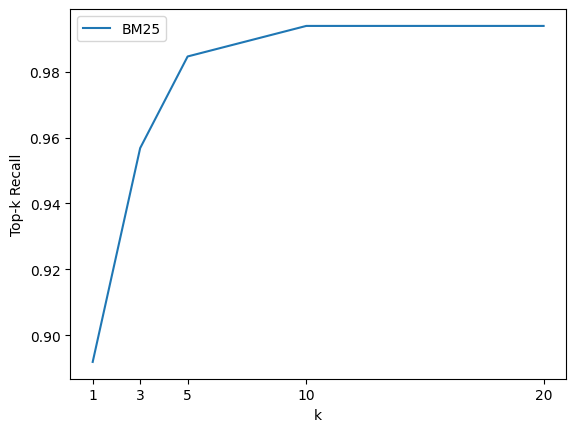

In [94]:
plot_retriever_eval([bm25_topk_df], ['BM25'])

```
그래프를 보면 k=5 에서 변곡점이 있고 k=10 부터 거의 완벽한 재현율을 달성함

그럼 이제 밀집 벡터 기법으로 추출한 문서를 확인해보자
```

#### DPR

```
희소 리트리버는 k=10 개 문서를 반환할 때 거의 완벽한 재현율을 달성했음

하지만 k 값이 그보다 작을 때 성능을 높일 방법이 있을까?

이렇게 하면 더 적은 개수의 문서를 리더로 보내 QA 파이프라인의 전체적인 레이턴시를 줄인다는 이점이 생김

BM25 같은 희소 리트리버의 주요 단점은 사용자 쿼리의 단어가 리뷰에 들어있지 않으면 연관된 문서를 검색하지 못할 수 있다는 것임

한 가지 희망적인 대안은 밀집 임베딩을 사용해 질문과 문서를 표현하는 것임

DPR(Dense Passage Retriever)이라 불리는 구조가 현재 최고의 성능을 달성함

DPR 은 두 개의 BERT 모델을 사용해 질문과 구절을 인코딩한다는 개념에 기반함

아래 그림처럼 이런 인코더는 입력 텍스트를 [CLS] 토큰의 d 차원 벡터 표현으로 매핑함
```

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

```
헤이스택에서 DPR 을 위한 리트리버를 만든느 방법은 BM25 방법과 비슷함

문서 저장소를 지정하고, 질문가 구절을 위한 BERT 인코더를 선택함

선택한 인코더에 관련된 구절(양성)과 무관한 구절(음성)을 질문과 함께 주입해 훈련함

연관된 질문-구절 쌍이 높은 유사도를 가지도록 학습하는 것이 목표임

이 예제에서는 NQ 말뭉치에서 미세 튜닝한 인코더를 사용하겠음
```

In [95]:
from haystack.retriever.dense import DensePassageRetriever

In [96]:
dpr_retriever = DensePassageRetriever(document_store=document_store,
                                      query_embedding_model='facebook/dpr-question_encoder-single-nq-base',
                                      passage_embedding_model='facebook/dpr-ctx_encoder-single-nq-base',
                                      embed_title=False)

INFO - haystack.modeling.utils -  Using devices: CUDA:0, CUDA:1
INFO - haystack.modeling.utils -  Number of GPUs: 2


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-question_encoder-single-nq-base


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-ctx_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-ctx_encoder-single-nq-base


```
제품으로 필터링하므로 문서 제목(즉, item_id)을 연결해 추가 정보를 얻지 못하기 때문에 embed_title=False 로 지정했음

밀집 리트리버를 초기화한 후 다음 단계로 일래스틱서치에 인덱스된 문서를 모두 순회하면서 인코더를 적용해 임베딩 표현을 업데이트 함
```

In [97]:
document_store.update_embeddings(retriever=dpr_retriever)

INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 1615 docs ...


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

```
이제 모두 준비됐음!

BM25 와 같은 방식으로 밀집 리트리버를 평가하고 탑-k 재현율을 비교하겠음
```

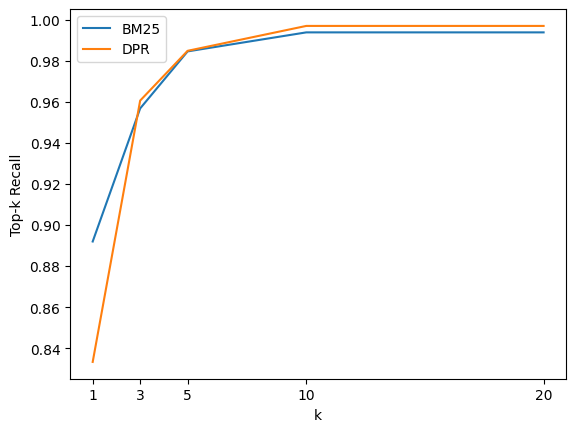

In [98]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ['BM25', 'DPR'])

```
그래프를 보면 DPR 은 재현율이 BM25 보다 k=3 이후부터 높아짐
```

> TIP<br>페이스북의 FAISS 라이브러리(https://oreil.ly/1E8Z0)를 문서 저장소로 사용하면 임베딩의 유사도 검색 속도가 높아짐<br>비슷하게 대상 도메인에서 미세 튜닝을 해도 DPR 리트리버의 성능이 향상됨<br>DPR 을 미세 튜닝하는 방법을 알고 싶다면 헤이스택 튜토리얼(https://oreil.ly/eXyro)을 참고

```
지금까지 리트리버 평가에 대해 알아보았으니 리더 평가로 넘어가겠음
```

### 7.2.2 리더 평가하기

추출적 QA 에서 리더를 평가하는 주요 지표는 두 가지임


##### EM(Exact Match)

```
예측과 정답에 있는 문자가 정확히 일치하면 EM = 1 이고 그렇지 않으면 EM = 0 인 이진 지표임

답이 없다고 예상되면 텍스트를 전혀 예측하지 못하는 것처럼 모델은 EM = 0 을 받음
```

##### F1-점수

```
정밀도와 재현율의 조화 평균을 측정
```

In [99]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

In [100]:
pred = 'about 6000 hours'
label = '6000 hours'
print(f'EM: {compute_exact(label, pred)}')
print(f'F1: {compute_f1(label, pred)}')

EM: 0
F1: 0.8


```
내부적으로 이 함수들은 구두점 삭제, 공백 수정, 소문자 변환을 적용해 먼저 예측과 레이블을 정규화함

그다음 정규화된 문자열을 BoW 로 토큰화함

마지막으로 토큰 수준에서 측정 지표를 계산함

앞의 간단한 샘플을 통해 EM 이 F1-점수보다 훨씬 더 엄격한 지표임을 확인했음

예측에 토큰이 하나라도 더 추가되면 EM 은 0이 됨

반면 F1-점수는 잘못된 답을 잡아내지 못하는 경우도 있음

예를 들어 예측한 답이 'about 6000 dollars (6000 달러 정도)' 일 경우 다음과 같은 결과가 나옴
```

In [101]:
pred = 'about 6000 dollars'
print(f'EM: {compute_exact(label, pred)}')
print(f'F1: {compute_f1(label, pred)}')

EM: 0
F1: 0.4


```
F1-점수에만 의존하면 결과가 왜곡될 가능성이 존재함

따라서 두 지표를 모두 참고해 모델 성능의 과소평가(EM)와 과대평가(F1-점수) 사이에서 균형을 잡는 게 좋은 전략임

보통 질문에는 유효한 답이 여러 개 있음

따라서 평가 세트에 있는 각각의 질문-답 쌍에 대해 이런 지표를 계산하고 가능한 답 중에서 가장 좋은 점수를 선택함

그다음 각각의 질문-답 쌍의 개별 점수를 평균해 모델의 전체적인 EM 과 F1-점수를 구함
```

In [102]:
from haystack.pipelines import Pipeline

In [111]:
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name='Reader', inputs=['Query'])
    
    eval_result = p.eval(
        labels=labels_agg,
        documents=[[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
    
    return {k: v for k, v in metrics['Reader'].items() if k in score_keys}

In [112]:
reader_eval = {}
reader_eval['Fine-tune on SQuAD'] = evaluate_reader(reader)

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, round

In [113]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind='bar', ylabel='Score', rot=0, ax=ax)
    ax.set_xticklabels(['EM', 'F1'])
    plt.legend(loc='upper left')
    plt.show()

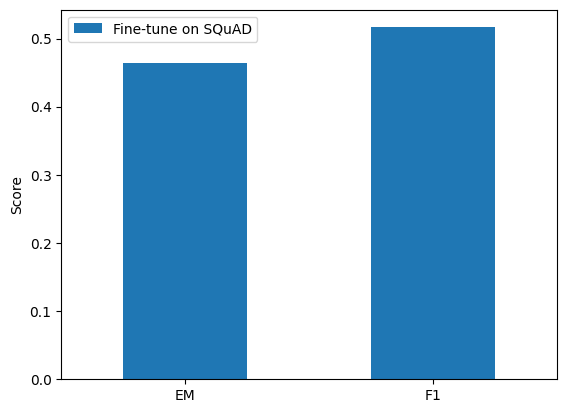

In [114]:
plot_reader_eval(reader_eval)

```
MiniLM 이 EM 점수 76.1 F1-점수 79.5인 SQuAD 2.0 보다 SubjQA 에서 모델의 성능이 크게 떨어지는 것 같음

성능이 저하된 이유 하나는 고객 리뷰가 SQuAD 2.0 데이터셋을 만드는 데 사용한 위키피디아 항목 본문과 크게 다르고 리뷰가 자유로운 형식으로 쓰였기 때문임

또 다른 이유는 위키피디아에 있는 사실 정보와 달리, 데이터셋의 질문과 답에는 주관성이 내재됐기 때문임

도메인 적응으로 모델을 SubjQA 에서 미세 튜닝하면 더 나은 결과가 나오는지 알아보자
```

### 7.2.3 도메인 적응

```
SQuAD 에서 미세 튜닝한 모델은 대개 다른 도메인에 잘 일반화되지만, SubjQA 에서 모델의 EM 과 F1-점수는 SQuAD 보다 훨씬 더 나쁨

이런 일반화 실패는 다른 추출적 QA 데이터셋에서도 관찰했는데, 이는 트랜스포머 모델이 SQuAD 데이터셋에 과대적합된 증거로 생각됨

리더의 성능을 가장 쉽게 향상하는 방법은 MiniLM 모델을 SubjQA 훈련 세트에서 미세 튜닝하는 것임

이를 위해 FARMReader 는 train() 메서드를 제공함

이 메서드는 SQuAD JSON 포맷으로 데이터를 입력받음

이 포맷은 아래 그림에서 보듯 아이템마다 질문-답 쌍을 모두 합친 것임
```

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

```
데이터 포맷이 매우 복잡하니 판다스를 사용해 변환하겠음

먼저 각 제품 ID 에 연관된 paragraphs 배열을 만드는 함수를 구현함

이 배열의 원소는 하나의 문맥(즉, 리뷰)과 질문-답 쌍의 배열인 qas 를 담고 있음

paragraphs 배열을 만든느 함수는 다음과 같음
```

In [115]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df['review_id'], df['context']))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍을 필터링함
        review_df = df.query(f'review_id == "{review_id}"')
        id2question = dict(zip(review_df['id'], review_df['question']))
        # qas 배열을 만듦
        for qid, question in id2question.items():
            # 하나의 질문 ID 에 대해 필터링함
            question_df = df.query(f"id == '{qid}'").to_dict(orient='list')
            ans_start_idxs = question_df['answers.answer_start'][0].tolist()
            ans_text = question_df['answers.text'][0].tolist()
            # 답변 가능한 질문을 추가함
            if len(ans_start_idxs):
                answers = [
                    {'text': text, 'answer_start': answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)
                ]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas 에 추가
            qas.append({'question': question, 'id': qid,
                        'is_impossible': is_impossible, 'answers': answers})
        # 문맥과 질문-답 쌍을 paragraphs 에 추가
        paragraphs.append({'qas': qas, 'context': review})
    return paragraphs

```
하나의 제품 ID 에 연관된 DataFrame 의 열을 전달해 SQuAD 포맷을 만듦
```

In [116]:
product = dfs['train'].query('title == "B00001P4ZH"')

In [117]:
product

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective,n_tokens
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.5,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4AA and QZ-99. The Koss Portapr...",How is the bass?,[],[],[],[],[],155
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.5,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,"To anyone who hasn't tried all the various types of headphones, it is import...",Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as expected, even with EQ adjusted up]","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]",537
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.5,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,"I have had many sub-$100 headphones from $5 Panasonic to $100 Sony, with Sen...",How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True],534


In [118]:
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

```
마지막으로 이 함수를 각 분할의 DataFrame 에 있는 모든 제품 ID 에 적용함

다음 convert_to_squad 함수는 이 과정을 수행하고 그 결과를 electronics-{split].json 파일에 저장
```

In [119]:
import json

In [130]:
def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID 에 대해 `paragraphs` 를 만듦
        groups = (df.groupby('title').apply(create_paragraphs)
                  .to_frame(name='paragraphs').reset_index())
        subjqa_data['data'] = groups.to_dict(orient='records')
        # 결과를 디스크에 저장함
        with open(f"electronics-{split}.json", "w+", encoding='utf-8') as f:
            json.dump(subjqa_data, f)

In [131]:
convert_to_squad(dfs)

```
이제 적절한 포맷으로 분할 세트를 준비했으니, 훈련과 개발 분할의 위치와 미세 튜닝한 모델을 지정할 위치를 지정해 리더를 미세 튜닝해보자
```

In [132]:
train_filename = 'electronics-train.json'
dev_filename = 'electronics-validation.json'

reader.train(data_dir='.', 
             use_gpu=True,
             n_epochs=1,
             batch_size=16,
             train_filename=train_filename,
             dev_filename=dev_filename)

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.data_handler.data_silo -  
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO - haystack.modeling.data_handler.data_silo -  LOADING TRAIN DATA
INFO - haystack.modeling.data_handler.data_silo -  ==================
INFO - haystack.modeling.data_handler.data_silo -  Loading train set from: electronics-train.json 
INFO - haystack.modeling.data_handler.data_silo -  Got ya 7 parallel workers to convert 1265 dictionaries to pytorch datasets (chunksize = 37)...
INFO - haystack.modeling.data_handler.data_silo -   0     0     0     0     0     0     0  
INFO - haystack.modeling.data_handler.data_silo -  /w\   /w\   /w\   /w\   /w\   /w\   /w\ 
INFO - haystack.modeling.data_handler.data_silo -  /'\   / \   /'\   /'\   / \   / \   /'\ 
P

```
미세 튜닝된 리더의 테스트 세트 성능을 기준 모델과 비교해보겠음
```

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, round

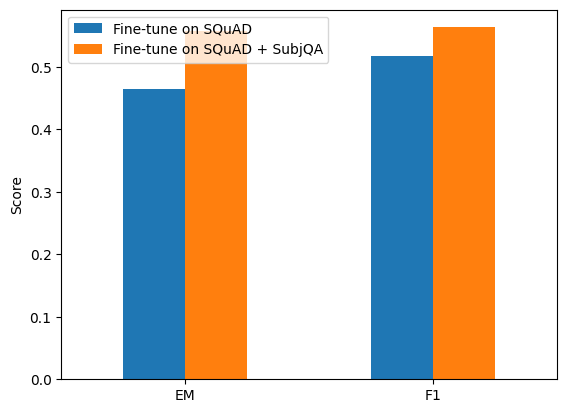

In [133]:
reader_eval['Fine-tune on SQuAD + SubjQA'] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

```
도메인 적응을 수행하니 EM 점수랑 F1-점수 모두 오름

지금쯤 사전 훈련된 언어 모델을 바로 SubjQA 훈련 세트에 미세 튜닝하지 않는 이유가 궁금할지 모르겠음

한 가지 이유는 SubjQA 훈련 샘플이 1,295개 뿐이고 SQuAD 에는 샘플이 100,000개 이상 있기 떄문임

따라서 과대적합이 발생할 위험이 있음

그럼에도 순진하게 미세 튜닝한 결과를 알아보겠음

공정한 비교를 위해 SQuAD 에서 기준 모델을 미세 튜닝할 때 사용한 언어 모델을 그대로 사용함

이전처럼 FARMReader 로 모델을 로드함
```

In [134]:
minilm_ckpt = 'microsoft/MiniLM-L12-H384-uncased'
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt,
                           progress_bar=False,
                           max_seq_len=max_seq_length,
                           doc_stride=doc_stride,
                           return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CUDA:0, CUDA:1
INFO - haystack.modeling.utils -  Number of GPUs: 2
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find microsoft/MiniLM-L12-H384-uncased locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded microsoft/MiniLM-L12-H384-uncased
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 7 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0     0     0     0     0     0  
INFO - haystack.modeling.infer -  /w\   /w\   /w\   /w\   /w\   /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \   /'\   /'\   / \   / \   /'\ 


```
한 에포크 동안 미세 튜닝함
```

In [135]:
minilm_reader.train(data_dir='.',
                    use_gpu=True,
                    n_epochs=1,
                    batch_size=16,
                    train_filename=train_filename,
                    dev_filename=dev_filename)

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.data_handler.data_silo -  
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO - haystack.modeling.data_handler.data_silo -  LOADING TRAIN DATA
INFO - haystack.modeling.data_handler.data_silo -  ==================
INFO - haystack.modeling.data_handler.data_silo -  Loading train set from: electronics-train.json 
INFO - haystack.modeling.data_handler.data_silo -  Got ya 7 parallel workers to convert 1265 dictionaries to pytorch datasets (chunksize = 37)...
INFO - haystack.modeling.data_handler.data_silo -   0     0     0     0     0     0     0  
INFO - haystack.modeling.data_handler.data_silo -  /w\   /w\   /w\   /w\   /w\   /w\   /w\ 
INFO - haystack.modeling.data_handler.data_silo -  /'\   / \   /'\   /'\   / \   / \   /'\ 
P

```
테스트 세트에서 평가해 이전 결과와 비교해보자
```

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, round

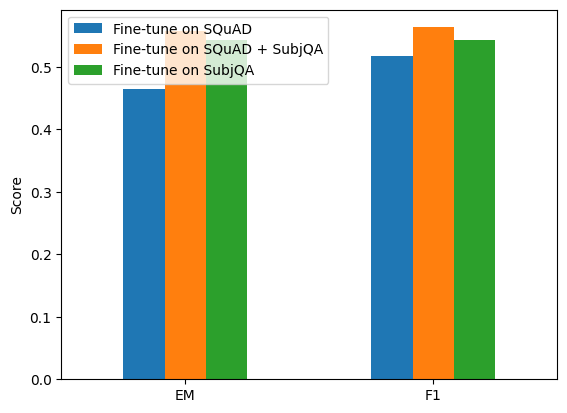

In [136]:
reader_eval['Fine-tune on SubjQA'] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

```
SubjQA 에서 바로 미세 튜닝한 언어 모델은 SQuAD 와 SubjQA 에서 미세 튜닝한 모델보다 성능이 떨어짐
```

> WARNING<br>작은 데이터셋을 다룰 때 과대적합하기 쉬운 트랜스포머 모델을 평가하려면 교차 검증(Cross Validation)을 사용하는 것이 좋음<br>SQuAD 포맷의 데이터셋으로 교차 검증을 수행하는 방법은 FARM 저장소에 있는 예제(https://oreil.ly/K3nK8)를 참고

### 7.2.4 전체 QA 파이프라인 평가하기

```
리더와 리트리버를 개별적으로 평가하는 방법을 알았으니 이를 연결해 파이프라인의 전체 성능을 평가하겠음

k=10 에서 거의 완벽한 재현율을 얻었음

따라서 이 값을 수정해 (SQuAD 스타일의 평가와 달리 쿼리마다 여러 개의 문맥을 받기 때문에) 리더의 성능에 미치는 영향을 평가하겠음
```

In [137]:
from haystack.pipelines import ExtractiveQAPipeline

In [138]:
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# 평가하기!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표를 추출합니다
reader_eval['QA pipeline (top-1)'] = {
    k: v for k, v in metrics['Reader'].items()
    if k in ['exact_match', 'f1']
}

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, round

```
리트리버가 반환한 문서에서 정답을 예측하는 모델의 탑-1 EM 과 탑-1 F1-점수를 비교하겠음
```

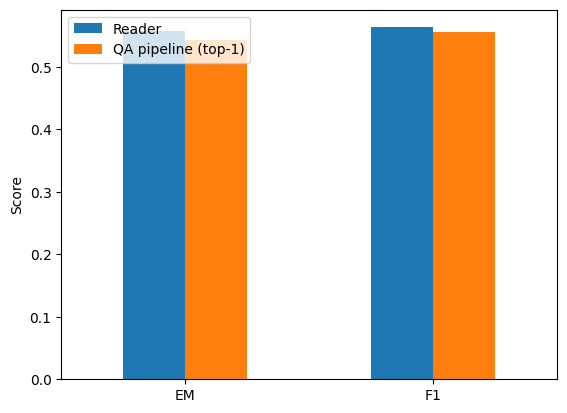

In [140]:
plot_reader_eval({'Reader': reader_eval['Fine-tune on SQuAD + SubjQA'],
                  'QA pipeline (top-1)': reader_eval['QA pipeline (top-1)']})

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, round

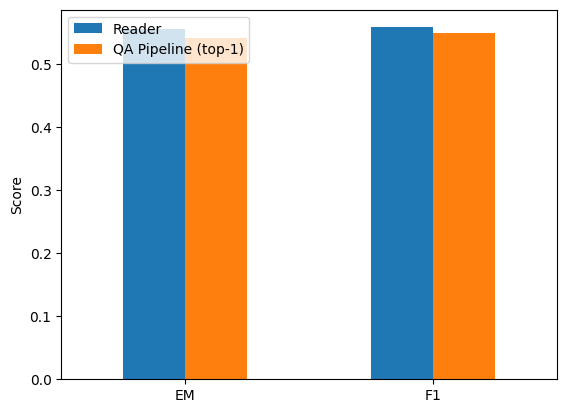

In [141]:
# 또는 QA 파이프라인과 리더 지표를 한번에 얻음
# 리더 평가는 시뮬레이트된 완벽한 리트리버 결과를 사용해 두 번째로 실행됨
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 시뮬레이트된 완벽한 리트리버로 격리되어 실행된 리더로부터 지표를 추출함
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode='isolated')

pipeline_reader_eval = {}
pipeline_reader_eval['Reader'] = {
    k: v for k, v in isolated_metrics['Reader'].items()
    if k in ['exact_match', 'f1']
}
pipeline_reader_eval['QA Pipeline (top-1)'] = {
    k: v for k, v in metrics['Reader'].items()
    if k in ['exact_match', 'f1']
}

plot_reader_eval(pipeline_reader_eval)

```
이 그래프에서 리트리버가 전체 성능에 미치는 영향을 볼 수 있음

SQuAD 스타일의 평가에서와 같이 질문-문맥 쌍을 매칭하는 것에 비해 전체적으로 감소했음

이 문제는 리더가 예측하는 답변의 개수를 증가시켜 피할 수 있음

지금까지 문맥에서만 답 범위를 추출했음

하지만 보통 답은 문서 전체에 흩어져 있음

이럴 때는 모델이 조각을 모아 일관된 하나의 답으로 합성해야 함

이런 작업을 위해 생성적 QA(Generated QA)를 사용하는 방법을 알아보겠음
```

## 7.3 추출적 QA 를 넘어서

```
문서에서 텍스트 범위로 답을 추출하는 것의 흥미로운 대안은 사전 훈련된 언어 모델로 답을 생성하는 것임

이런 방법을 종종 추상적 QA(Abstractive QA) 또는 생성적 QA(Generative QA)라고 함

여러 구절에 흩어진 증거를 합성해 더 나은 문장으로 답을 구성함

추출적 QA 보다 더 성숙하진 않지만 빠르게 성장하는 연구 분야이므로 여러분이 이 책을 읽을 즈음이면 업계에 널리 적용되어 있을 가능성이 높음

이 절에서 현재 최고의 성능을 내는 RAG(Retrieval-Augmented Generation)에 대해 간단히 살펴보겠음

RAG 는 이 장에서 살펴본 고전적인 리트리버-리더 구조를 확장함

리더를 제너레이터(Generator)로 바꾸고 리트리버로 DPR 을 사용함

제너레이터는 T5 나 BART 같은 사전 훈련된 시퀀스-투-시퀀스 트랜스포머임

DPR 로부터 문서의 잠재 벡터를 받고 쿼리와 문서를 기반으로 답변을 반복적으로 생성함

DPR 과 제너레이터가 미분 가능하기 때문에 아래 그림과 같이 전체 과정을 엔드-투엔드로 미세 튜닝할 수 있음
```

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_rag-architecture.png?raw=1" id="rag"/>

```
RAG 를 구동하기 위해 앞에서 만든 dpr_retriever 를 사용하겠음

따라서 제너레이터만 만들면 됨

이때 선택 가능한 RAG 모델은 두 종류임
```

##### RAG-시퀀스

```
하나의 추출 문서를 사용해 완전한 답을 생성함

특히 리트리버가 반환한 탑-k 개 문서를 제너레이터에 주입해 각 문서에서 출력 시퀀스를 만들고 이 결과를 합쳐(Marginalize) 최선의 답을 얻음
```

##### RAG-토큰

```
여러 문서를 사용해 답에 있는 각 토큰을 생성함

제너레이터가 여러 문서에서 단서를 찾아 합성함
```

RAG-토큰 모델이 RAG-시퀀스보다 성능이 더 좋으니 NQ 에서 미세 튜닝한 토큰 모델을 제너레이터로 사용하겠음

헤이스택에서 제너레이터를 초기화하는 것은리더를 초기화하는 것과 비슷함

하지만 문맥 위를 슬라이딩하는 윈도를 위해 max_seq_length 와 doc_stride 매개변수를 지정하는 대신 텍스트 생성을 제어하는 하이퍼파라미터를 지정함

In [142]:
from haystack.generator.transformers import RAGenerator

In [143]:
generator = RAGenerator(model_name_or_path='facebook/rag-token-nq',
                        embed_title=False, num_beams=5)

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1


Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


```
num_beams 는 빔 서치에 사용할 빔 크기를 지정함 (텍스트 생성은 5장에서 자세히 다뤘음)

말뭉치를 항상 제품 ID 로 필터링하기 때문에 DPR 리트리버에서 했던 것처럼 문서 제목에 임베딩하지 않음

다음 작업으로 헤이스택의 GenerativeQAPipe 을 사용해 리트리버와 제너레이터를 연결함
```

In [144]:
from haystack.pipeline import GenerativeQAPipeline

WARNING - haystack -  Object 'GenerativeQAPipeline' is imported through a deprecated path. Please check out the docs for the new import path.


In [145]:
pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

> NOThaystackr>RAG 에서 쿼리 인코더와 제너레이터는 모두 엔드-투-엔드로 훈련됨<br>반면 문맥 인코더는 동결함<br>헤이스택에서 GenerativeQAPipeline 은 RAGenerator 의 쿼리 인코더와 DensePassageRetriever 의 문맥 인코더를 사용함

```
이전처럼 아마존 파이어 태블릿에 대한 쿼리를 주입해 RAG 를 실행하겠음

이를 위해 쿼리를 받고 최상의 답을 출력하는 간단한 함수를 만들겠음
```

In [146]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={'Retriever': {'top_k': 5,
                                           'filters': {'item_id': ['B0074BW614']}},
                             'Generator': {'top_k': top_k_generator}})
    print(f'질문: {preds["query"]} \n')
    for idx in range(top_k_generator):
        print(f"답변 {idx+1}: {preds['answers'][idx].answer}")

In [147]:
generate_answers(query)

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/transformers/models/rag/tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/transformers/generation_utils.py:1747: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


질문: Is it good for reading? 

답변 1:  the screen is absolutely beautiful
답변 2:  the Screen is absolutely beautiful
답변 3:  Kindle fire


```
이 결과는 나쁜 답은 아니지만 질문의 주관적인 특징이 제너레이터를 혼동시킴

조금 더 사실에 관한 질문을 던져보자
```

In [148]:
generate_answers('What is the main drawback?')

/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/transformers/models/rag/tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/data/heerak/workspace/venv3.8/lib/python3.8/site-packages/transformers/generation_utils.py:1747: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


질문: What is the main drawback? 

답변 1:  the price
답변 2:  no flash support
답변 3:  the cost


```
훨씬 좋음!

SubjQA 에서 엔드-투-엔드로 RAG 를 미세 튜닝하면 더 좋은 결과를 얻음

이는 숙제로 남겨놓겠음

하지만 코드를 살펴보고 싶다면 트랜스포머스 저장소(https://oreil.ly/oZz4S)에 있는 스크립트를 시작점으로 참고하세요
```

## 7.4 결론

```
QA 를 빠르게 살펴봤음

아마 궁금한 질문이 많을 것임

이 장에서 QA 의 두 가지 방법(추출적 QA 와 생성적 QA)과 두 가지 검색 알고리즘(BM25 와 DPR)을 알아보았음

도메인 적응은 간단한 기법이지만 QA 시스템의 성능을 큰 폭으로 향상시킨다는 점을 확인했음

또 이런 시스템을 평가하기 위해 사용하는 대표적인 지표를 몇 가지 살펴보았음

여기서는 클로즈드 도메인 QA (즉, 전자 제품 도메인 하나)에 초점을 맞춰 살펴봤찌만 이 기법은 오픈 도메인 QA 로 쉽게 일반화 됨

관련 내용을 알고 싶다면 클라우데라 패스트 포워드(Cloudera Fast Forward)의 훌륭한 QA 시리즈(https://oreil.ly/Fd6lc)를 추천함

QA 시스템을 실전에 성공적으로 배포하기란 어려움

경험에 비추어보면 먼저 최종 사용자에게 유용한 검색 기능을 제공하고 나중에 추출 구성 요소를 제공하는 것이 많은 도움이 됨

이런 측면에서 볼 때 리더는 온-디맨드(On-Demand) 사용자 쿼리에 답변을 제공하는 기능 외에 새로운 방식으로 사용할 수 있음

예를 들면 그리드 다이나믹스(Grid Dynamics(https://oreil.ly/CGLh1))의 연구자들은 리더를 사용해 고객 카탈로그에 설명된 제품의 장단점을 자동으로 추출함

또 'What kind of camera? (어떤 종류의 카메라인가요?)' 같은 쿼리를 생성하여 개체명을 제로샷(Zero-Shot) 방식으로 추출하기 위해 리더를 사용했음

아직 초창기인 점과 미묘한 실패 사례를 고려할 때 다른 두 가지 방식을 모두 적용해본 후에 생성적 QA 를 살펴보길 권함

QA 문제를 해결하기 위한 '요구 계층' 은 아래 그림과 같음
```

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-pyramid.png?raw=1" id="qa-pyramid"/> 

```
앞으로는 텍스트, 표, 이미지 같은 여러 형태를 아우르는 멀티모달 QA(MultiModal QA)가 흥미로운 연구 분야로 자리잡을 것임

MultiModalQA 벤치마크에서 설명했듯, 이 시스템은 'When was the famous painting with two touching fingers completed? (두 손가락이 맞닿는 명화는 언제 완성됐나요?)'와 같이 여러 종류의 정보를 통합하는 복잡한 질문에 답할 수 있음

실용적인 비즈니스 애플리케이션이 가능한 또 다른 영역은 지식 그래프(Knowledge Graph)에 대한 QA 임

이 그래프의 노드는 실제 세상의 엔티티(Entity)에 해당하며 이들의 관계는 에지(Edge)로 정의됨

(주어 ,술어, 목적어) 쌍으로 사실을 인코딩해 누락된 요소에 대한 질문에 답하기 위해 이 그래프를 사용함

트랜스포머와 지식 그래프를 연결한 예는 헤이스택 튜토리얼(https://oreil.ly/n7lZb)을 참고

전도 유망한 또 다른 분야는 레이블링되지 않은 데이터나 데이터 증식(Data Augmentation)을  사용해 비지도 또는 약 지도 훈련(Weakly Supervised Training)의 형태로 수행되는 자동 질문 생성(Automatic Question Generation)임

PAQ(Probably Answered Questions) 벤치마크와 교차 언어 설정을 위한 합성 데이터 증식에 관한 논문이 최근에 발표된 두 사례임

이 장에서 실전에서 QA 모델을 성공적으로 사용하기 위해 몇 가지 트릭을 적용했음

예를 들면 거의 실시간으로 에측을 만들기 위해 빠른 추출 파이프라인을 구현했음

사전에 선택된 약간의 문서에 QA 모델을 적용하는 것은 제품 환경의 하드웨어에서 여전히 몇 초의 시간이 걸림

별것 아닌 것처럼 들리지만 구글 검색 결과를 몇 초 동안 기다린다면 사용자 경험이 얼마나 달라질지 상상해봐라

대기 시간 몇 초가 트랜스포머를 사용한 애플리케이션의 운명을 결정할 수 있음

다음 장에서 모델 예측의 속도를 더 높이는 방법을 살펴보겠음
```